In [1]:
# fitbit_heart_rate.py
import fitbit
from datetime import datetime, timedelta
import datetime as dt
import time
from fitbit_keys import fitbit_api
import pandas as pd
from pytz import timezone
import math
from functools import reduce

# Replace these with your Fitbit API credentials
CLIENT_ID = fitbit_api['OAuth 2.0 Client ID']
CLIENT_SECRET = fitbit_api['Client Secret']
# Regenerate everytime through https://dev.fitbit.com/build/reference/web-api/troubleshooting-guide/oauth2-tutorial/
#ACCESS_TOKEN = fitbit_api['Access Token']
REFRESH_TOKEN = fitbit_api['Refresh Token']
ACCESS_TOKEN = fitbit_api['Access Token']



In [2]:
import requests
import base64

# Get new ACCESS TOKEN and REFRESH TOKEN

def refresh_token(client_id, client_secret, refresh_token):
    auth_url = "https://api.fitbit.com/oauth2/token"
    
    # Prepare headers and body for the request
    headers = {
        "Content-Type": "application/x-www-form-urlencoded",
        "Authorization": f"Basic {base64.b64encode(f'{client_id}:{client_secret}'.encode()).decode()}"
    }
    body = {
        "grant_type": "refresh_token",
        "refresh_token": refresh_token
    }

    # Make the POST request
    response = requests.post(auth_url, headers=headers, data=body)

    # Handle the response
    if response.status_code == 200:
        # Parse the response as JSON
        response_json = response.json()

        # Extract the new access token and refresh token
        new_access_token = response_json["access_token"]
        new_refresh_token = response_json["refresh_token"]

        return new_access_token, new_refresh_token
    else:
        raise Exception(f"Failed to refresh token: {response.content}")
    

new_tokens = refresh_token(CLIENT_ID,CLIENT_SECRET,REFRESH_TOKEN)


In [3]:
# Update keys file
fitbit_api['Refresh Token'] = new_tokens[1]
fitbit_api['Access Token'] = new_tokens[0]

# ACCESS_TOKEN = new_tokens[0]
# REFRESH_TOKEN = new_tokens[1]
import json
with open('fitbit_keys.py', 'w') as f:
    f.write("fitbit_api = ")
    json.dump(fitbit_api, f)

In [4]:
# Create a Fitbit client
auth2_client  = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, access_token=fitbit_api['Access Token'], refresh_token=fitbit_api['Refresh Token'])

In [5]:
# Define the start date

start_date = datetime(2023,7,26)
today = datetime.today()

diff_days = math.ceil((today - start_date).total_seconds() / 86400)


print(diff_days)

list_of_dates = pd.date_range(start_date,periods=diff_days).tolist()
print(list_of_dates)

#today = datetime.today().strftime('%Y-%m-%d')

4
[Timestamp('2023-07-26 00:00:00'), Timestamp('2023-07-27 00:00:00'), Timestamp('2023-07-28 00:00:00'), Timestamp('2023-07-29 00:00:00')]


In [6]:
for i, date in enumerate(list_of_dates):
   list_of_dates[i] =  date.strftime('%Y-%m-%d')

list_of_dates

['2023-07-26', '2023-07-27', '2023-07-28', '2023-07-29']

In [7]:
# Old function

# def fitbit_stats(metric, date):
#     fitbit_intra_data = auth2_client.intraday_time_series(f'activities/{metric}', base_date=date, detail_level='1min')
#     time_list = []
#     val_list = []
#     for i in fitbit_intra_data[f'activities-{metric}-intraday']['dataset']:
#         val_list.append(i['value'])
#         time_list.append(i['time'])
#     df = pd.DataFrame({metric: val_list, 'Time': time_list})
#     # add date column
#     df['Date'] = date
#     # add timestamp column
#     df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
#     df = df[['Timestamp', metric]]
#     return df



In [8]:
# Defining functions to pull data from Fitbit API

def fitbit_stats(metric, date):
    # heart rate is available at 1-second detail level
    if metric == 'heart':
        detail_level = '1sec'
    else:
        detail_level = '1min'
        
    fitbit_intra_data = auth2_client.intraday_time_series(f'activities/{metric}', base_date=date, detail_level=detail_level)
    
    time_list = []
    val_list = []
    for i in fitbit_intra_data[f'activities-{metric}-intraday']['dataset']:
        val_list.append(i['value'])
        time_list.append(i['time'])
    df = pd.DataFrame({metric: val_list, 'Time': time_list})
    # add date column
    df['Date'] = date
    # add timestamp column
    df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    df = df[['Timestamp', metric]]
    # if metric is heart rate, resample and get mean heart rate for every minute
    if metric == 'heart':        
        df = df.resample('T', on='Timestamp').mean().reset_index()
        #df = df.dropna()
    return df


In [9]:
def combined_fitbit_stats(date):
    """Returns a dataframe with all fitbit stats for a given date."""
    metrics = [
        'heart', 'calories', 'steps', 'distance', 'minutesSedentary', 
        'minutesLightlyActive', 'minutesFairlyActive', 'minutesVeryActive',
        'elevation', 'floors', 
    ]

    dfs = [fitbit_stats(metric, date) for metric in metrics]
    merged_df = reduce(lambda left,right: pd.merge(left,right,on='Timestamp', how='outer'), dfs)
    #merged_df.dropna(subset=['heart'], inplace=True)
    return merged_df    



In [10]:
# For testing purposes get the heart rate data for a specific date
one_day_HR = fitbit_stats('heart', list_of_dates[0])
one_day_HR

,Timestamp,heart
0,2023-07-26 17:10:00,72.000
1,2023-07-26 17:11:00,NaN
2,2023-07-26 17:12:00,74.500
3,2023-07-26 17:13:00,75.900
4,2023-07-26 17:14:00,55.625
...,...,...
404,2023-07-26 23:54:00,51.125
405,2023-07-26 23:55:00,53.800
406,2023-07-26 23:56:00,59.900
407,2023-07-26 23:57:00,56.000


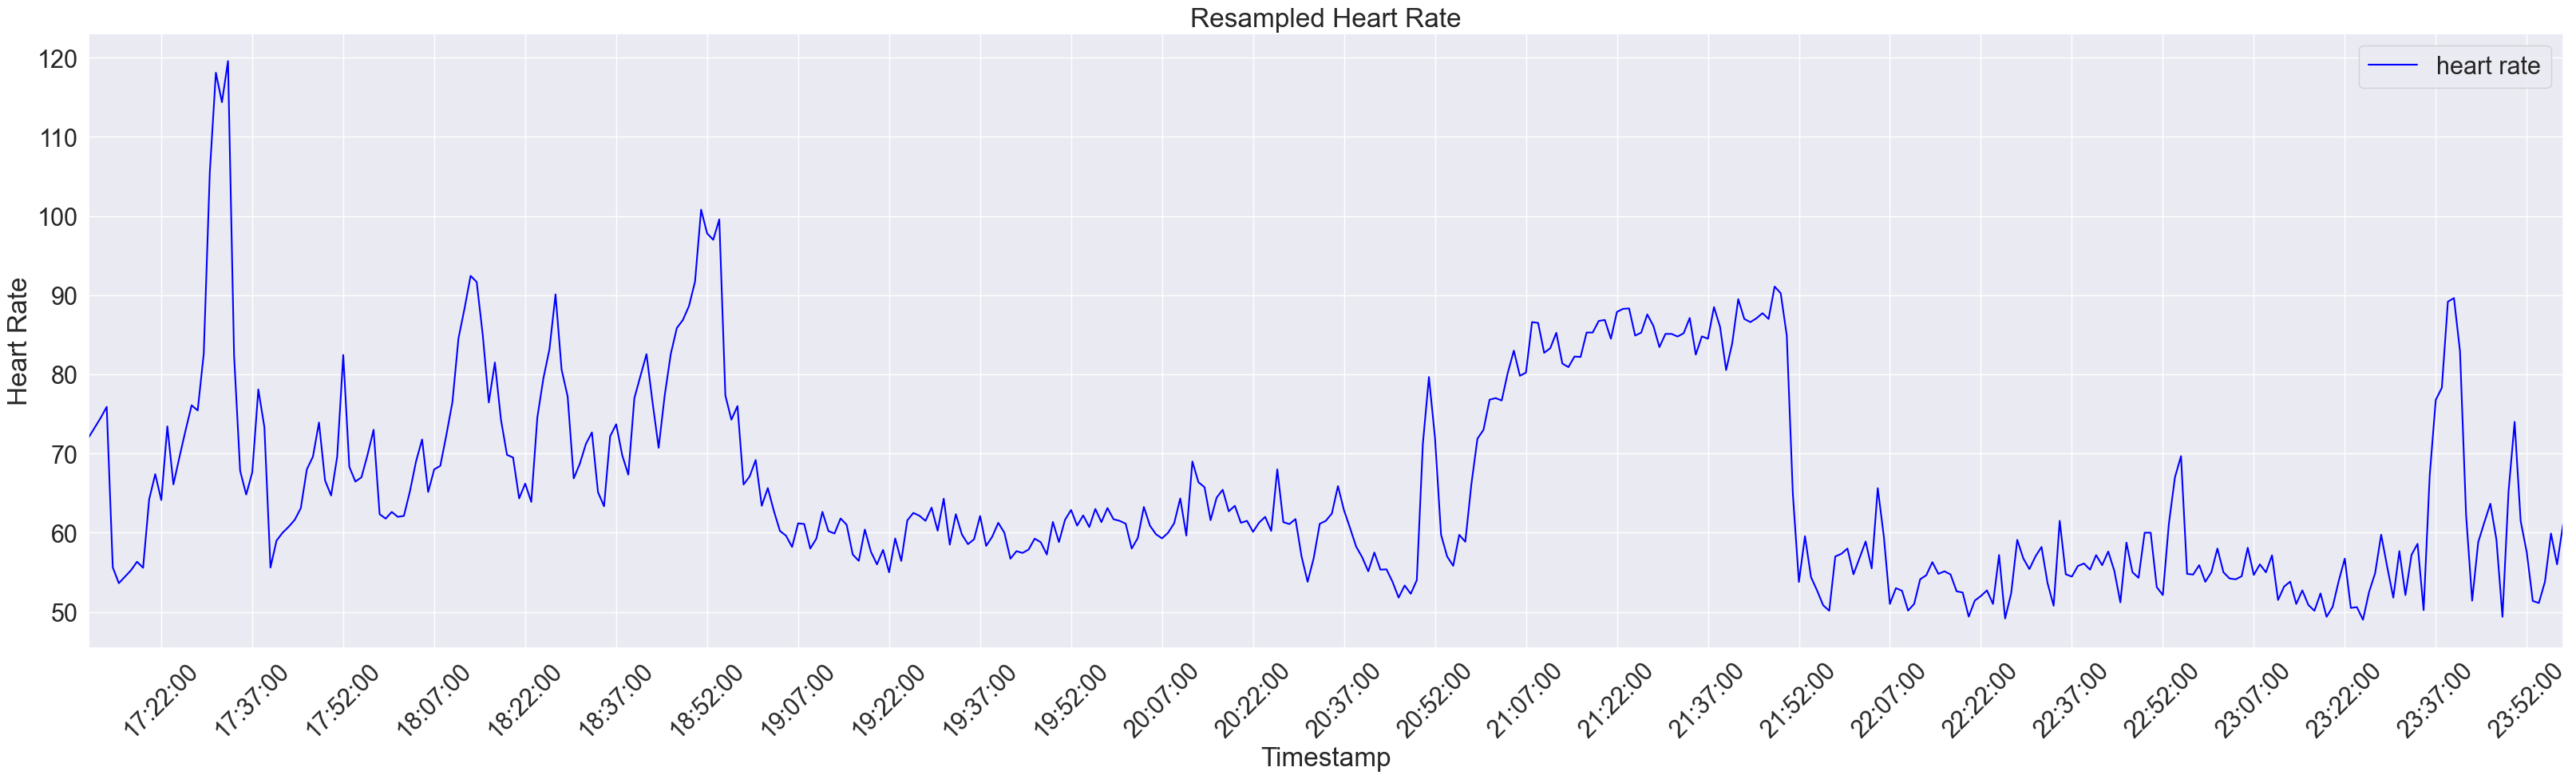

In [11]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator, MinuteLocator
import seaborn as sns
sns.set(rc={'figure.figsize':(40,10)}, font_scale = 2)

plot = sns.lineplot(data = one_day_HR, x = 'Timestamp', y = 'heart', color = 'blue', label = 'heart rate')
plt.xlabel('Timestamp')
plt.ylabel('Heart Rate')
plt.title('Resampled Heart Rate')
plt.legend()



# Set the x-axis labels as daytime
#x_dates = subset.index
date_format = DateFormatter("%H:%M:%S")  
plot.xaxis.set_major_formatter(date_format)

# Set the x-axis ticks at 7 AM and every hour thereafter
locator = MinuteLocator(interval=15, tz=None)
plot.xaxis.set_major_locator(locator)
plot.set_xlim(one_day_HR['Timestamp'].min(),
             one_day_HR['Timestamp'].max())




plt.xticks(rotation=45)
plt.show()

plt.show()
plt.show()


In [12]:
# Check first day
#combined_fitbit_stats(list_of_dates[0]).to_csv('check_fitbit_data.csv')

In [13]:
# Using a for loop to get combined fitbit data over a range of dates

data_dfs = []
for date in list_of_dates:
    data_dfs.append(combined_fitbit_stats(date))
    time.sleep(2) 
to_date_fitbit_data = pd.concat(data_dfs)


to_date_fitbit_data.set_index('Timestamp', inplace=True)
to_date_fitbit_data = to_date_fitbit_data.dropna(subset=['heart'])



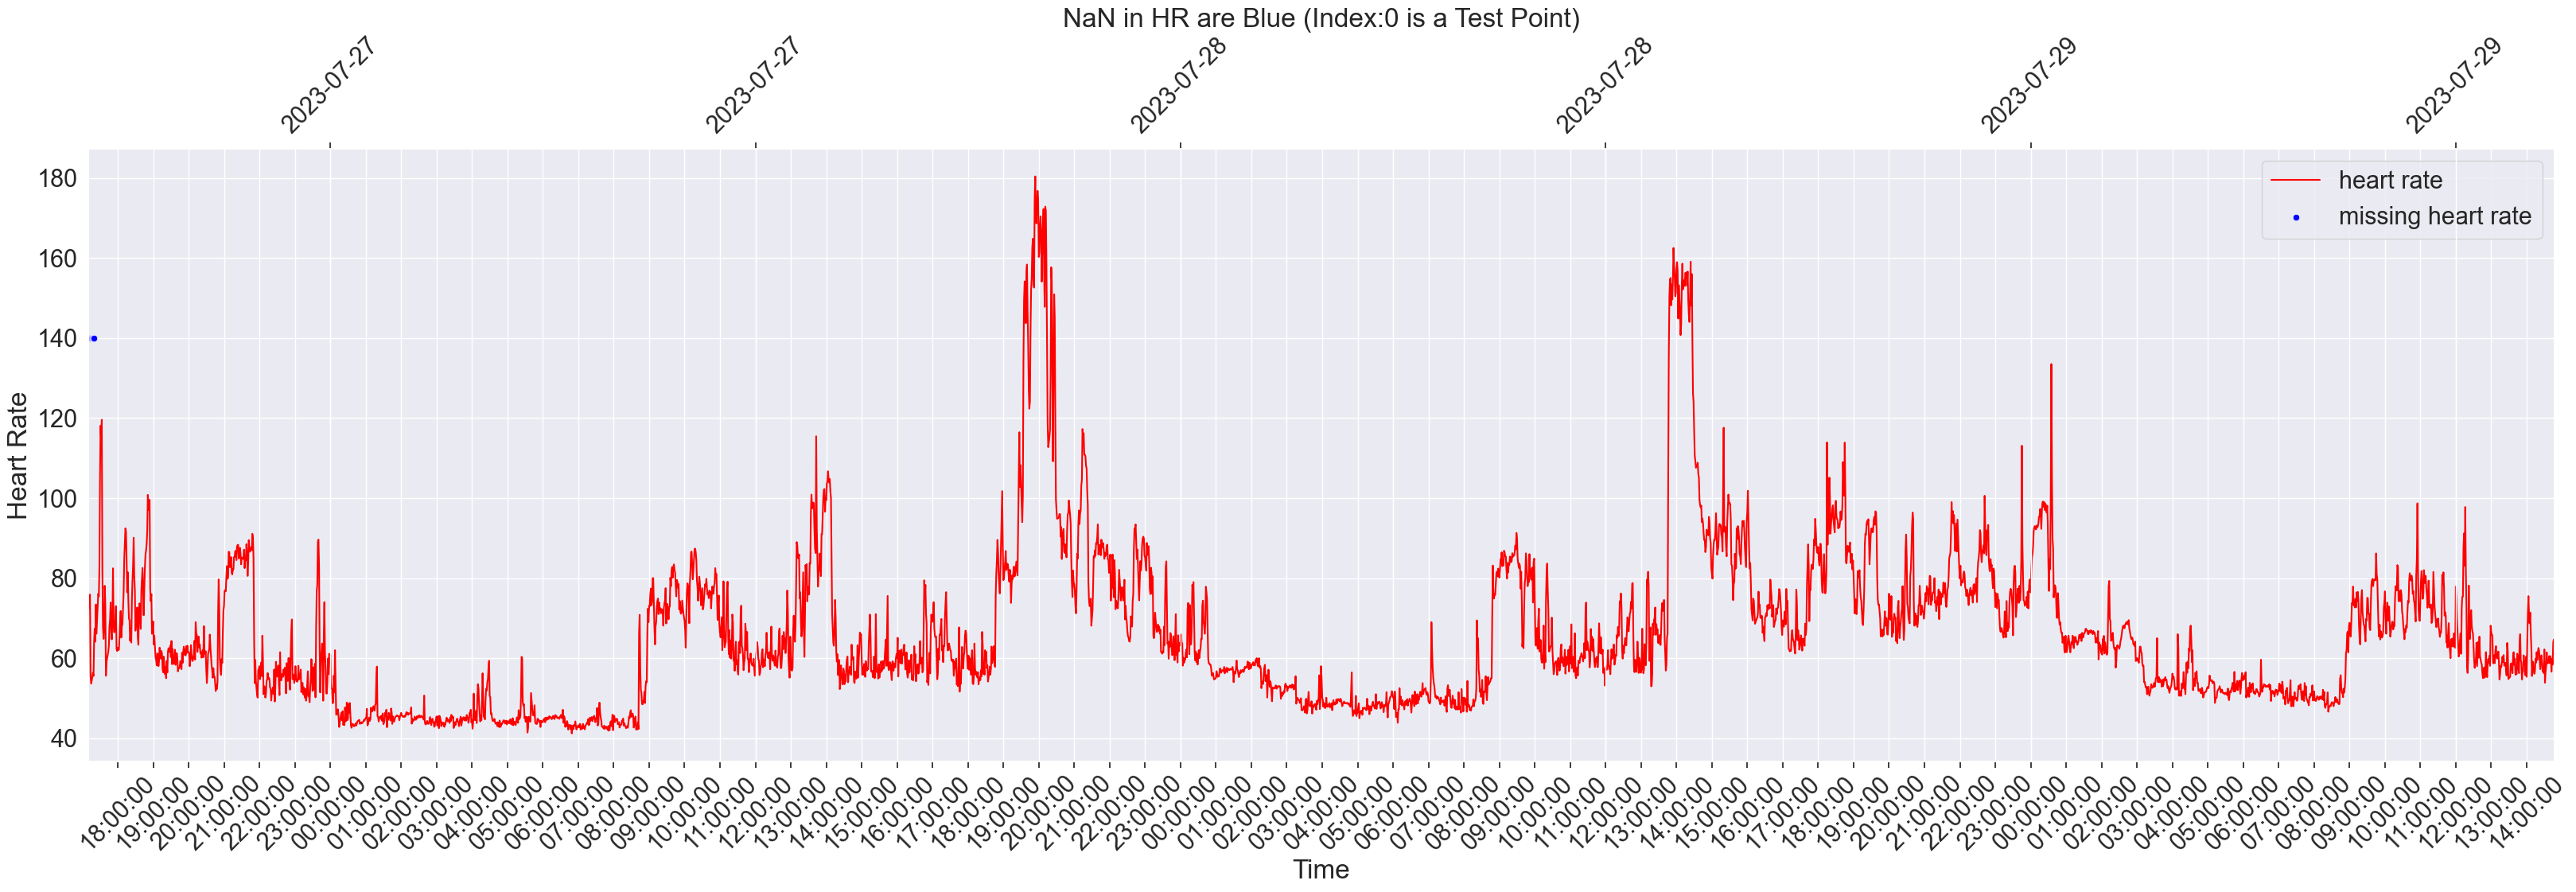

In [14]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator, MinuteLocator
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(40,10)}, font_scale = 2)
df_to_plot = to_date_fitbit_data
plt.close('all')
fig, ax1 = plt.subplots()

# Create a new column
df_to_plot['heart_nan'] = np.where(df_to_plot['heart'].isna(), 140, np.nan)
df_to_plot.iloc[0:10, df_to_plot.columns.get_loc('heart_nan')] = 140

# Plot the data 
plot = sns.lineplot(data = df_to_plot, x = df_to_plot.index, y = 'heart', color = 'red', label = 'heart rate', ax=ax1)
# Plot the new 'heart_nan' data
sns.scatterplot(data = df_to_plot, x = df_to_plot.index, y = 'heart_nan', color = 'blue', label = 'missing heart rate', ax=ax1)

ax1.set_xlabel('Time')
ax1.set_ylabel('Heart Rate')
ax1.set_title('NaN in HR are Blue (Index:0 is a Test Point)')

# Create the second axes, inheriting the x-axis from the first one
ax2 = ax1.twiny()

# Set the x-axis labels as daytime
date_format = DateFormatter("%H:%M:%S")  
ax1.xaxis.set_major_formatter(date_format)

# Set the x-axis ticks
locator = HourLocator(interval=1, tz=None)
ax1.xaxis.set_major_locator(locator)
ax1.set_xlim(df_to_plot.index.min(), df_to_plot.index.max())


# Format the second x-axis to show the date
date_format_day = DateFormatter("%Y-%m-%d")  
ax2.xaxis.set_major_formatter(date_format_day)
ax2.set_xlim(df_to_plot.index.min(), df_to_plot.index.max())

# Rotate x-axis labels on both axes
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)

plt.show()


In [15]:
to_date_fitbit_data.reset_index(drop=True).to_csv('./data/to_date_fitbit_data.csv', index=False)

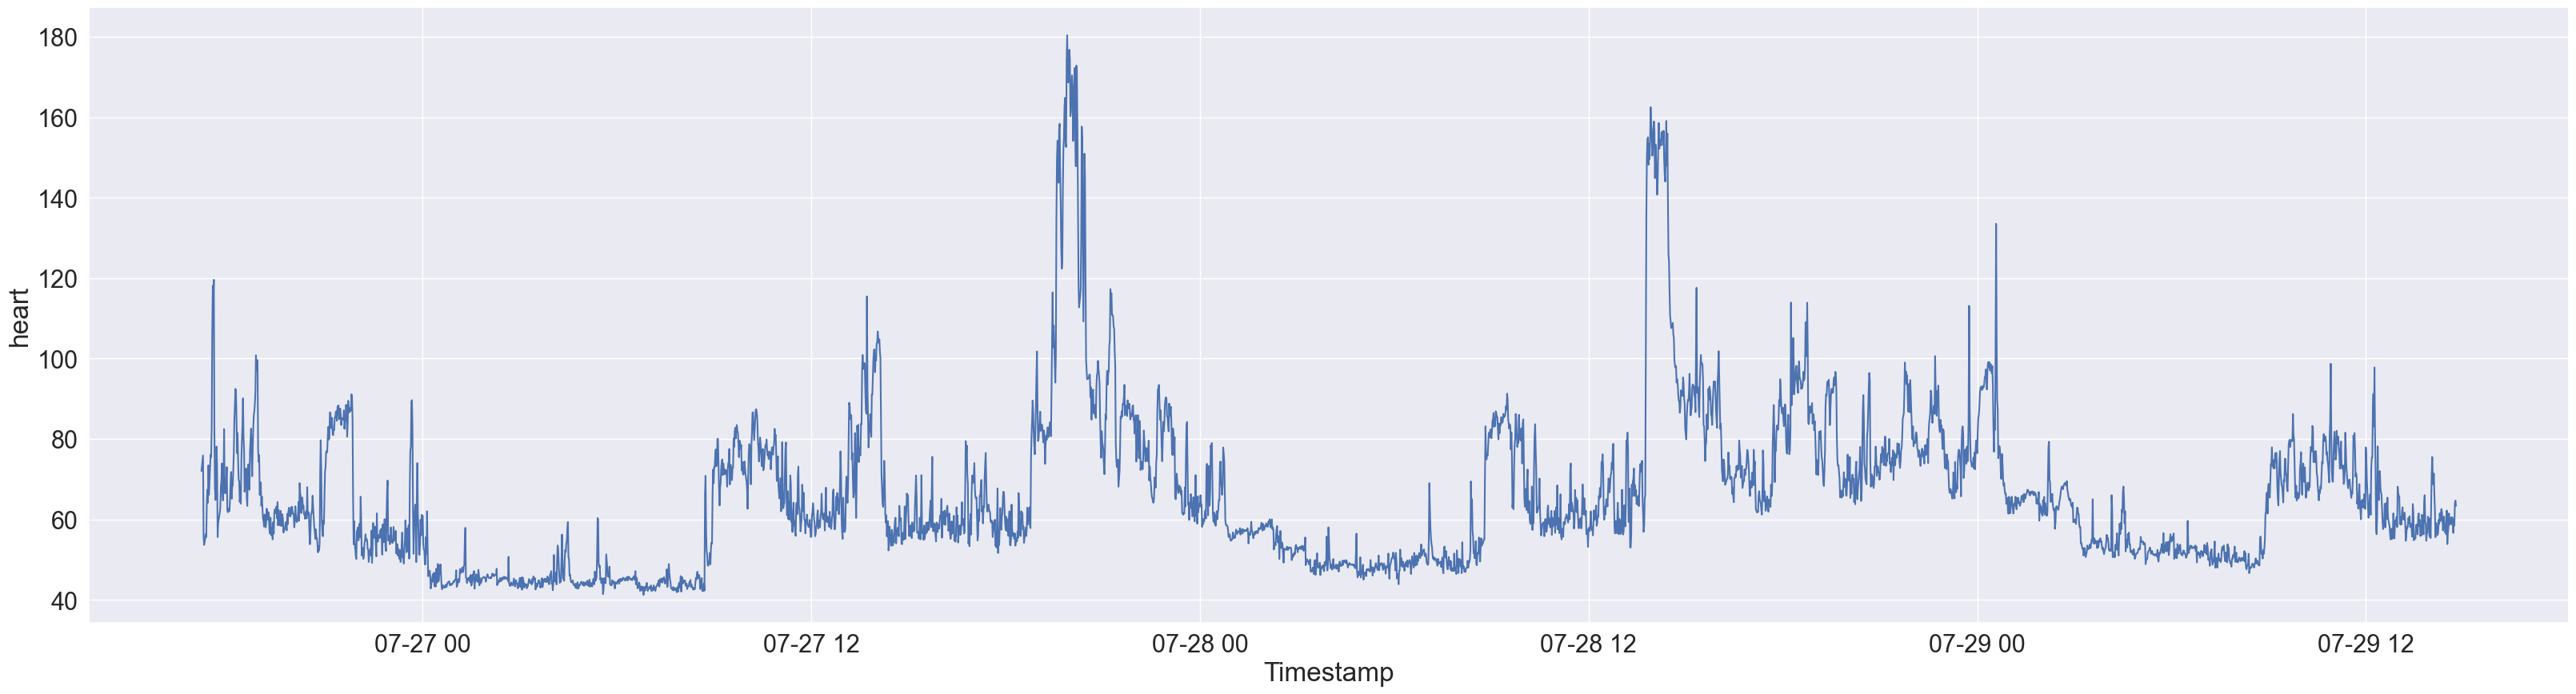

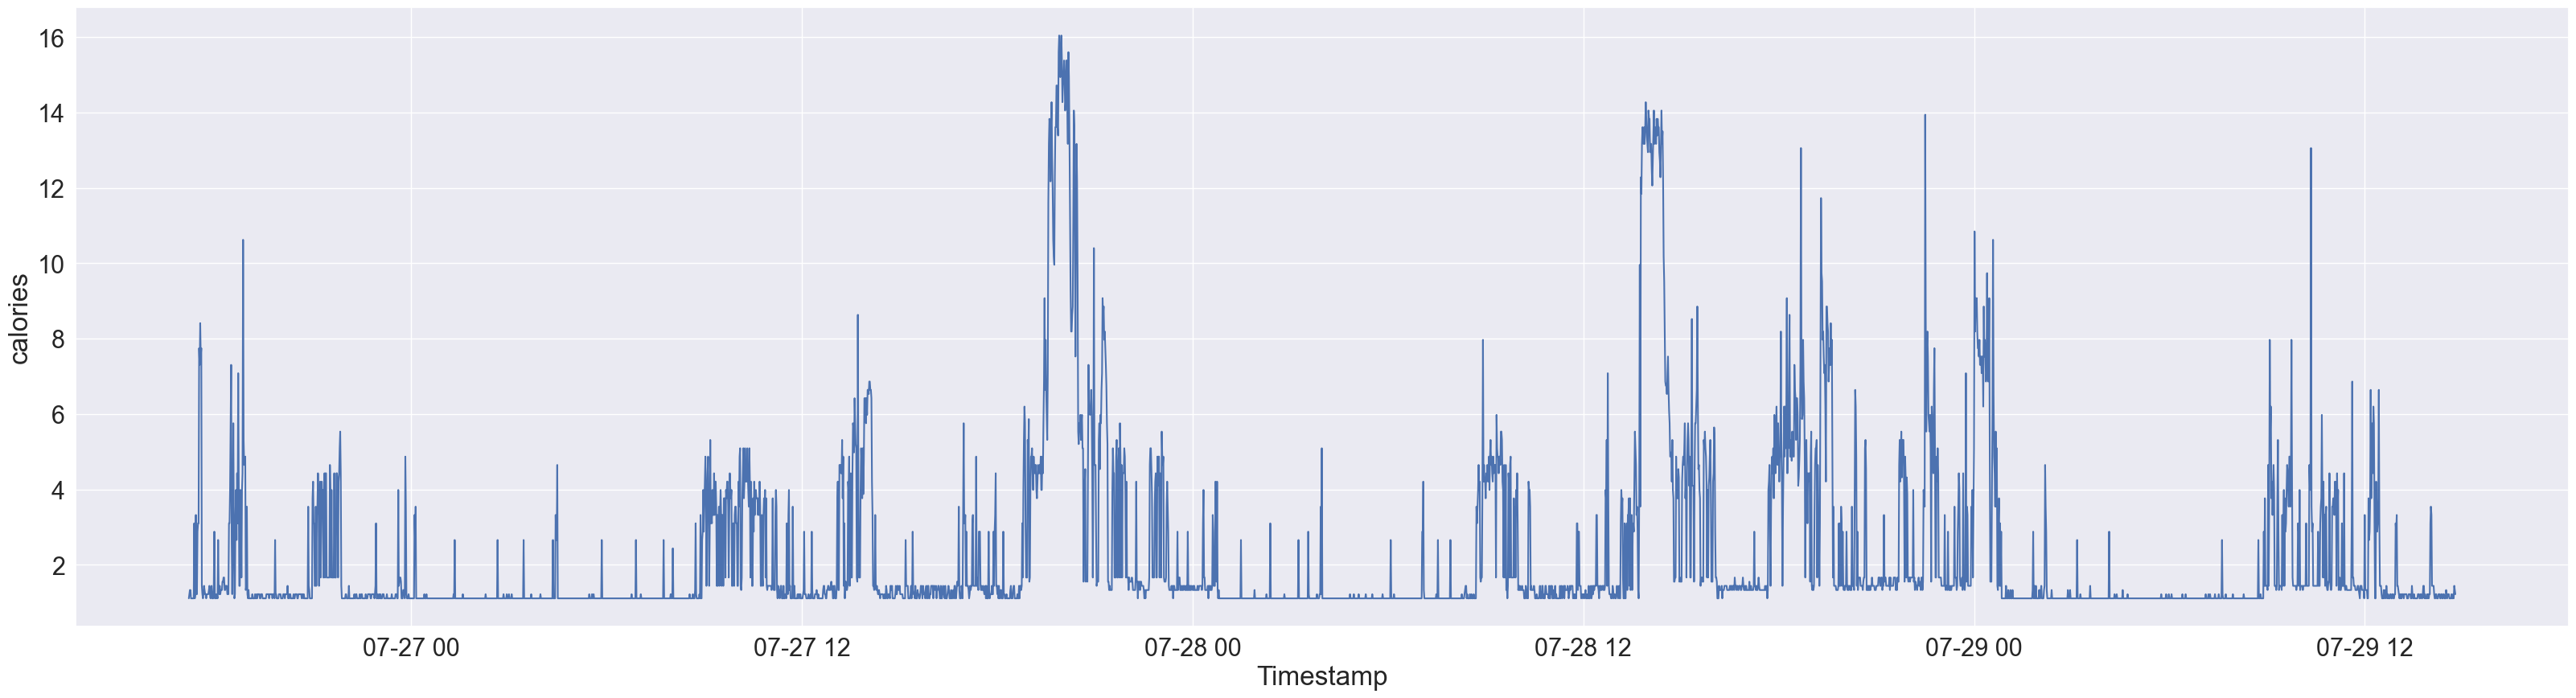

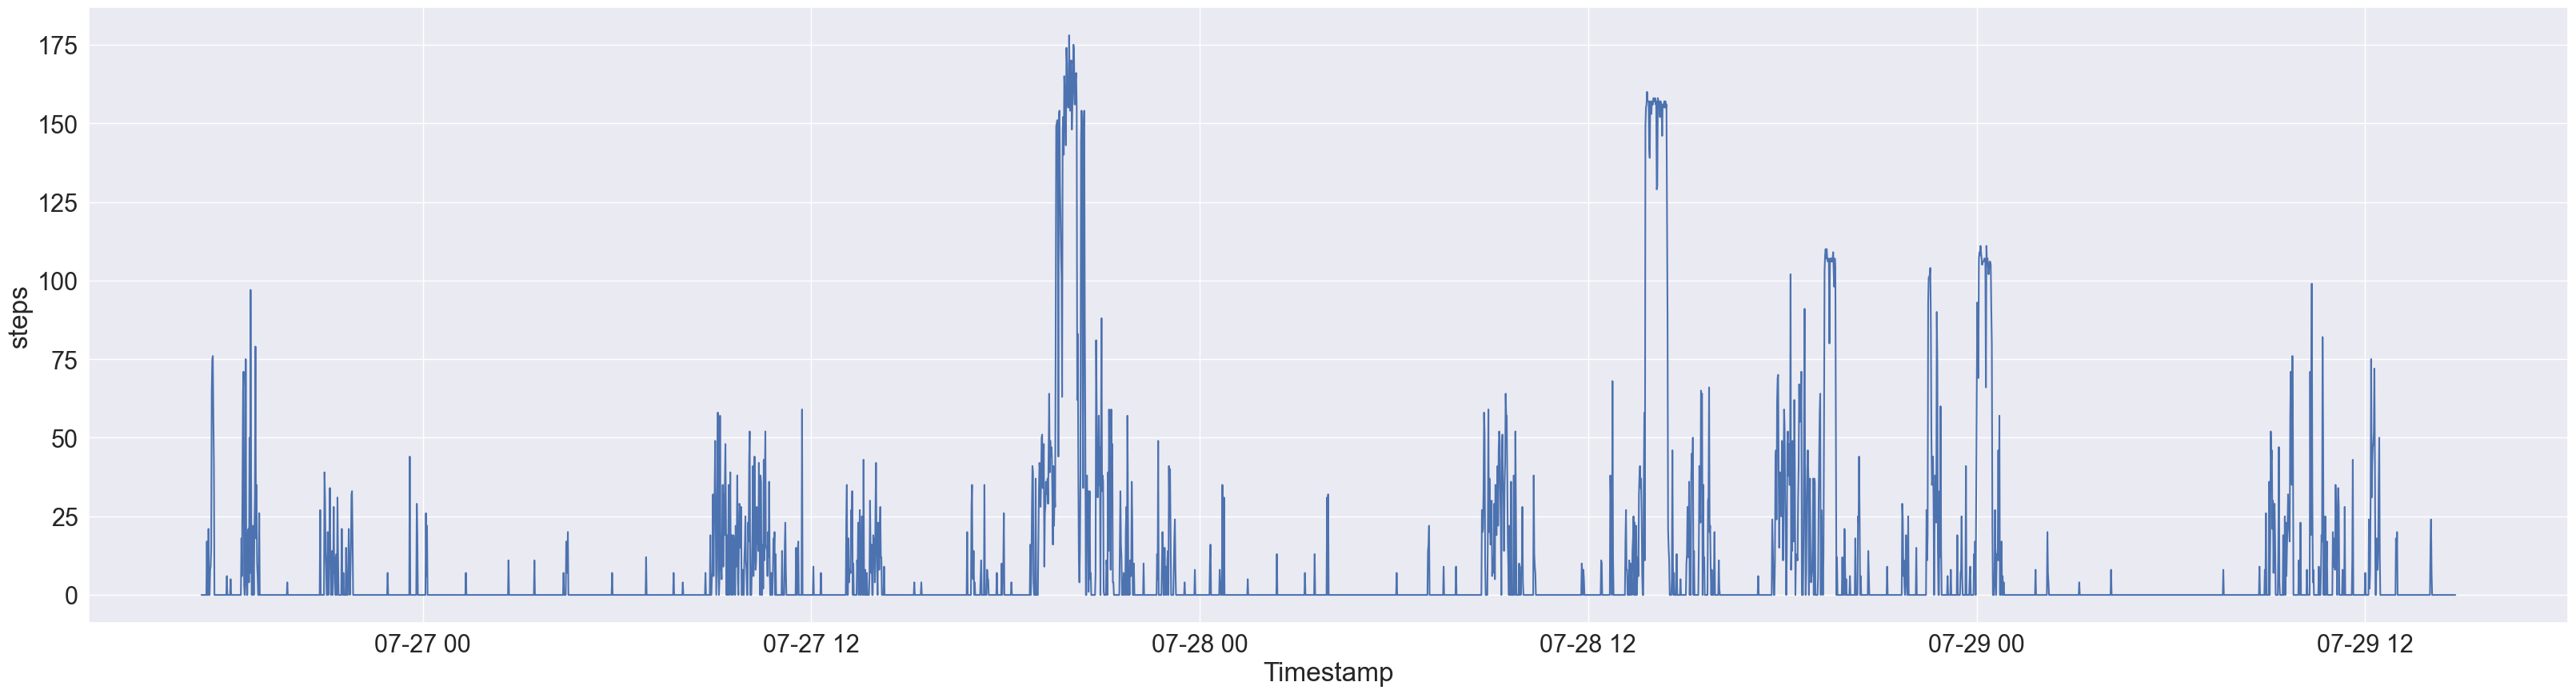

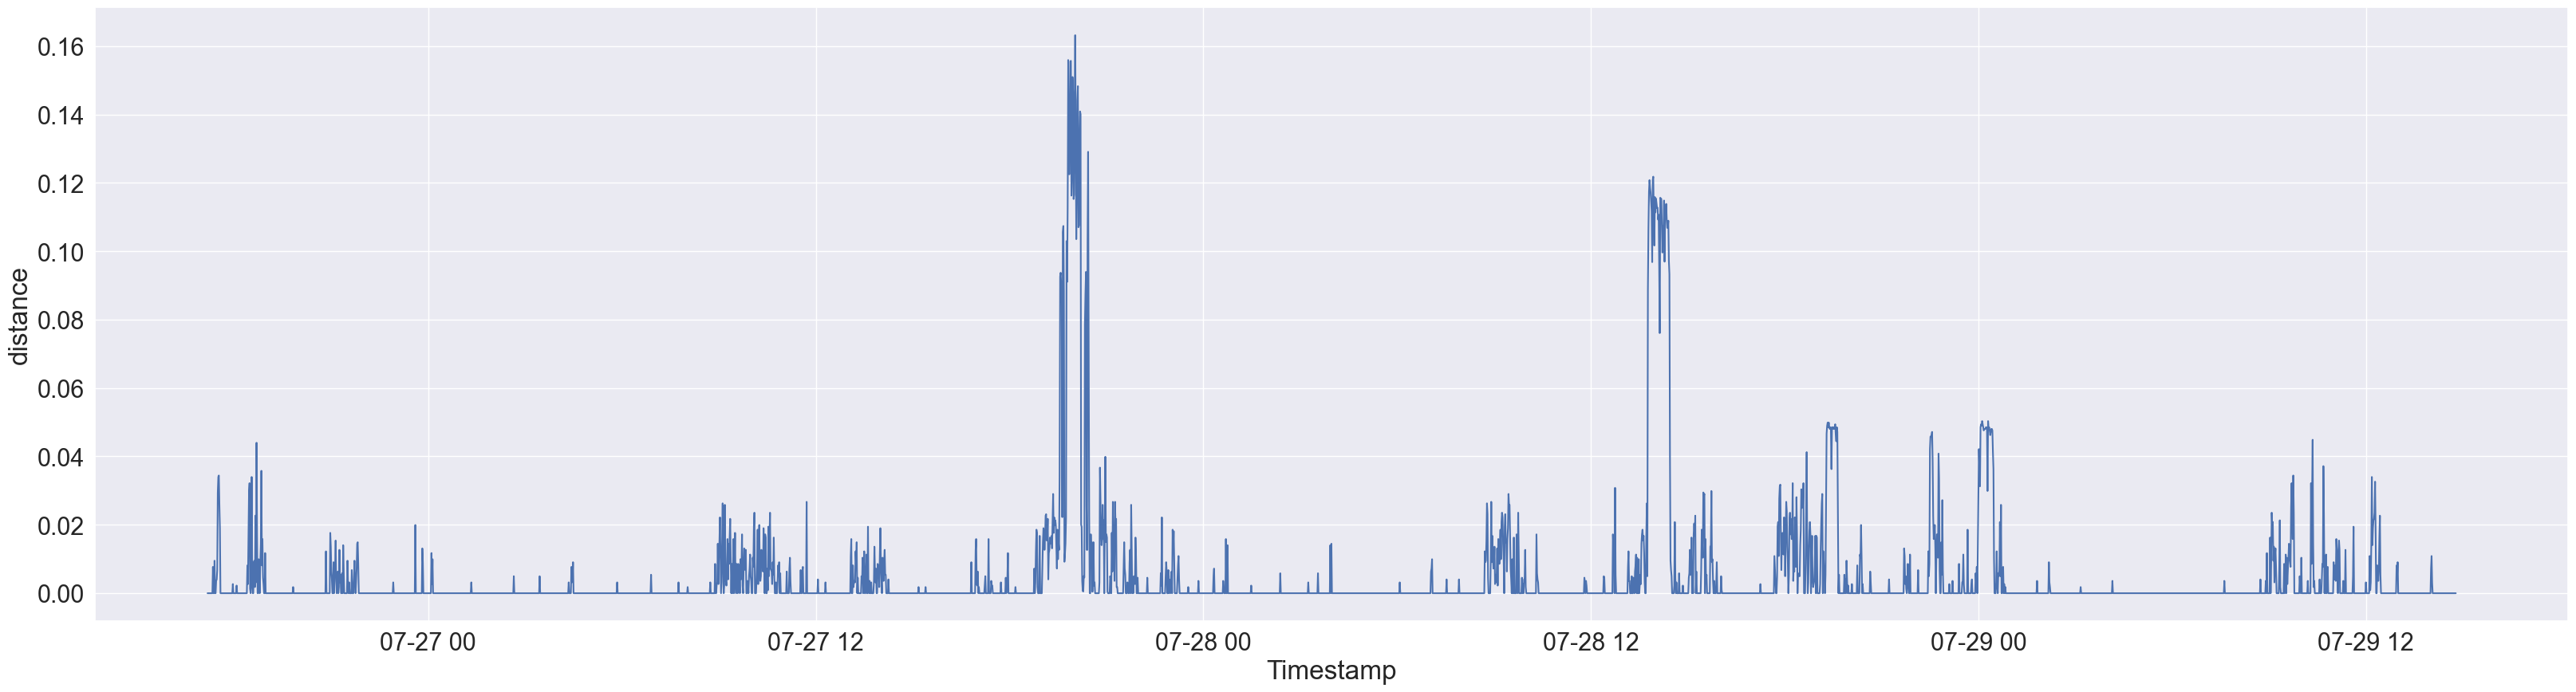

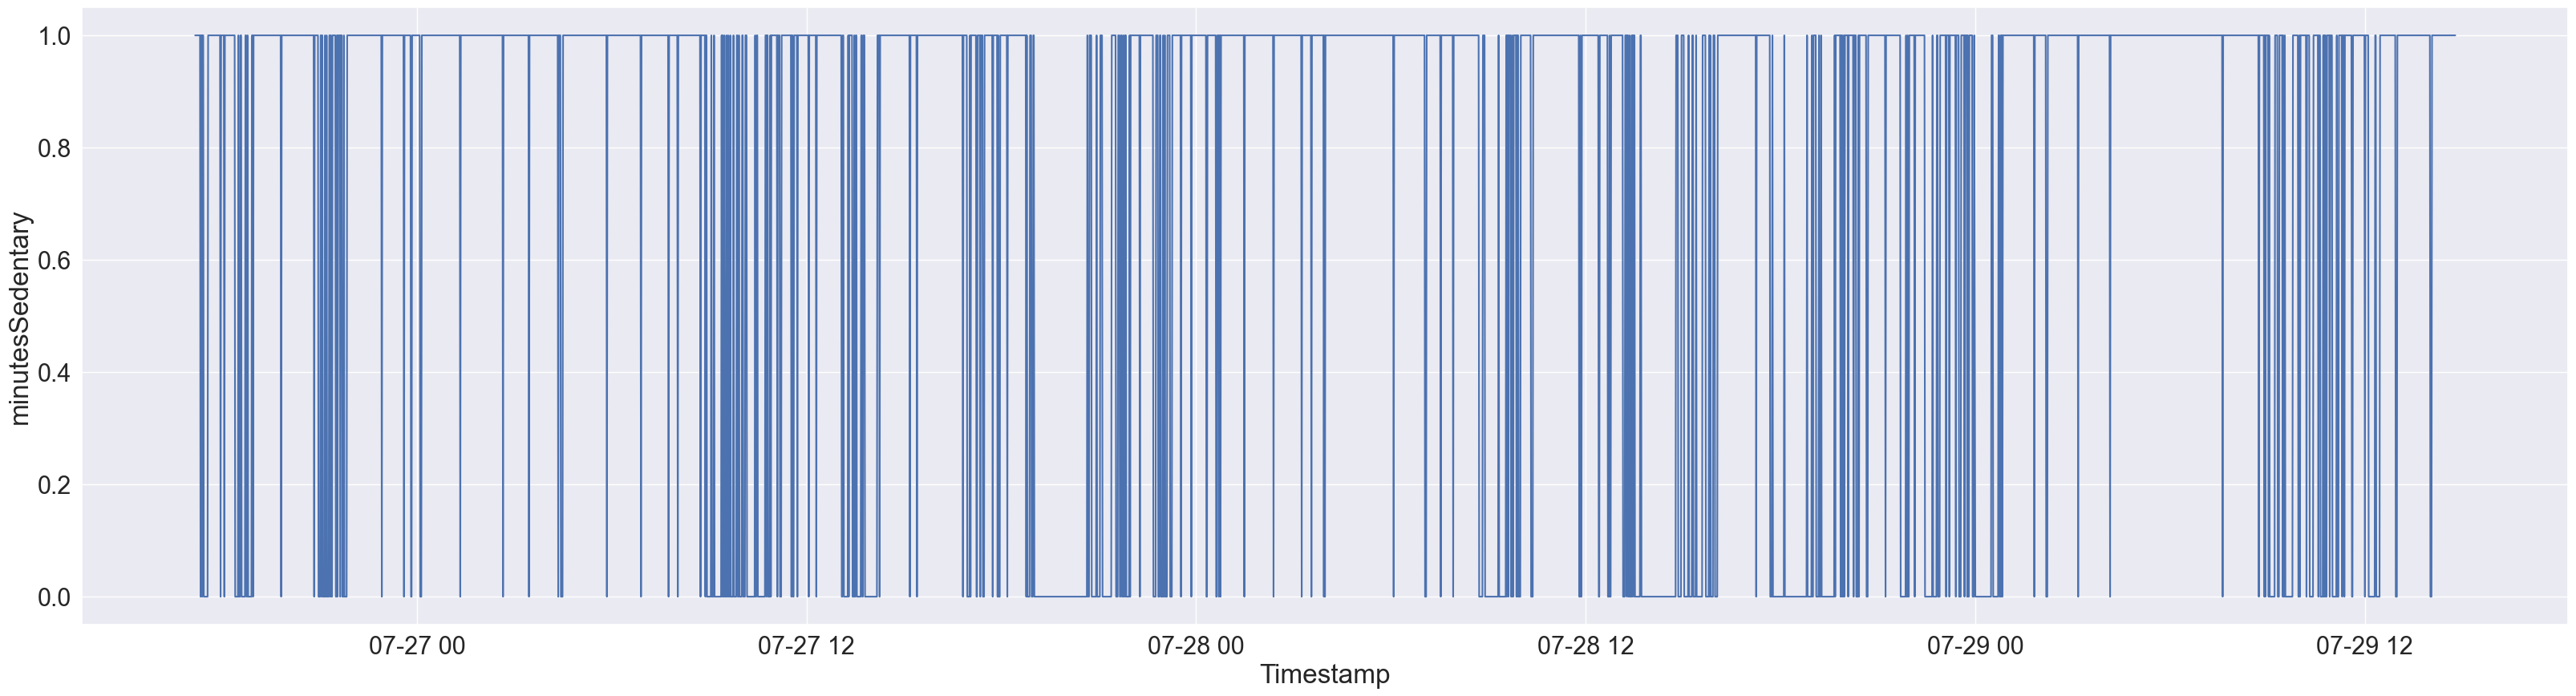

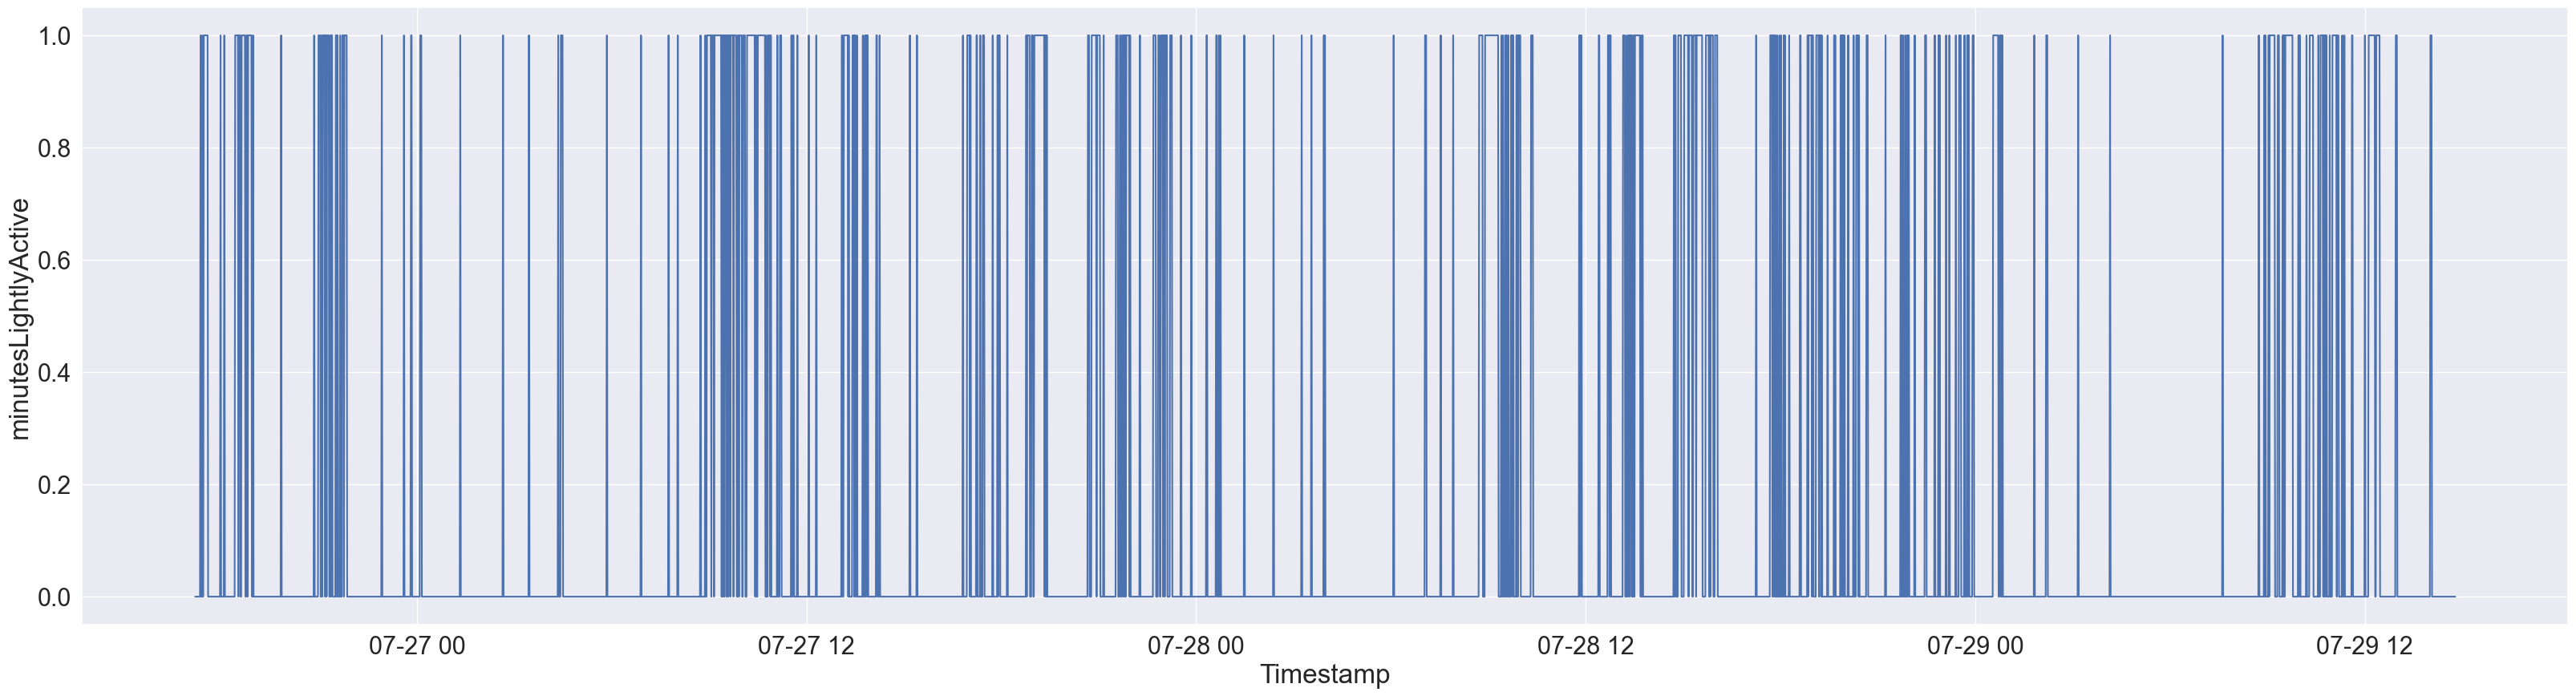

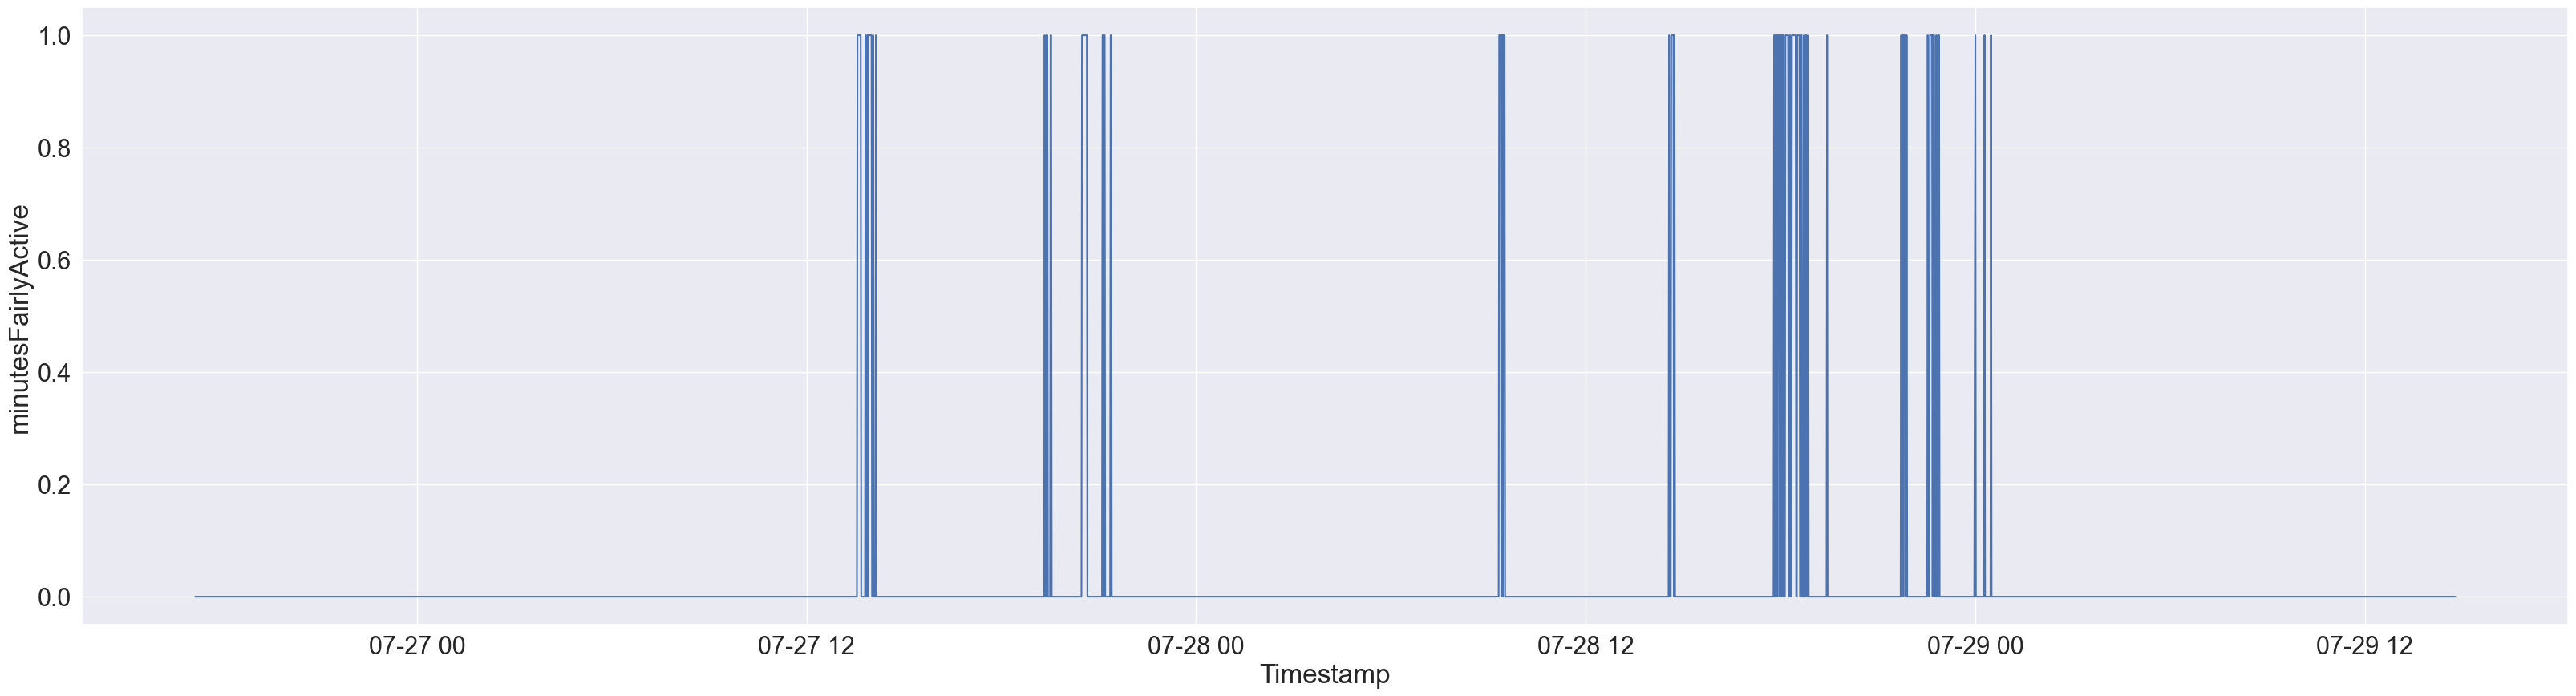

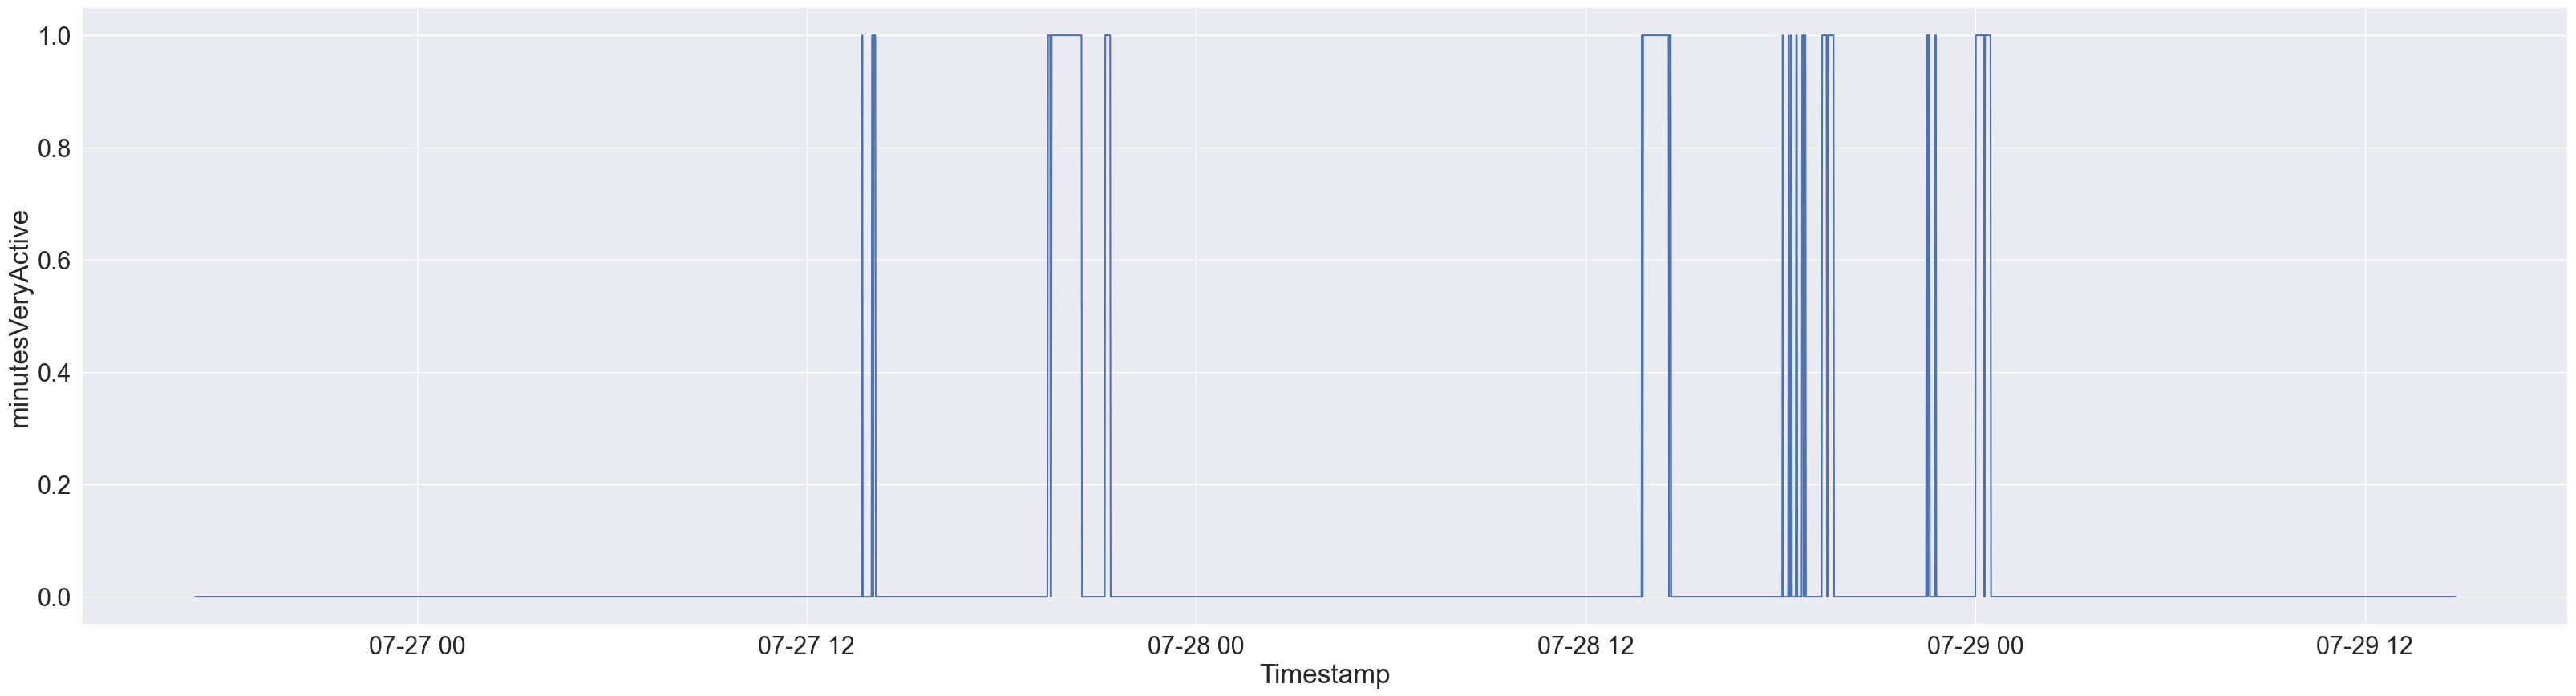

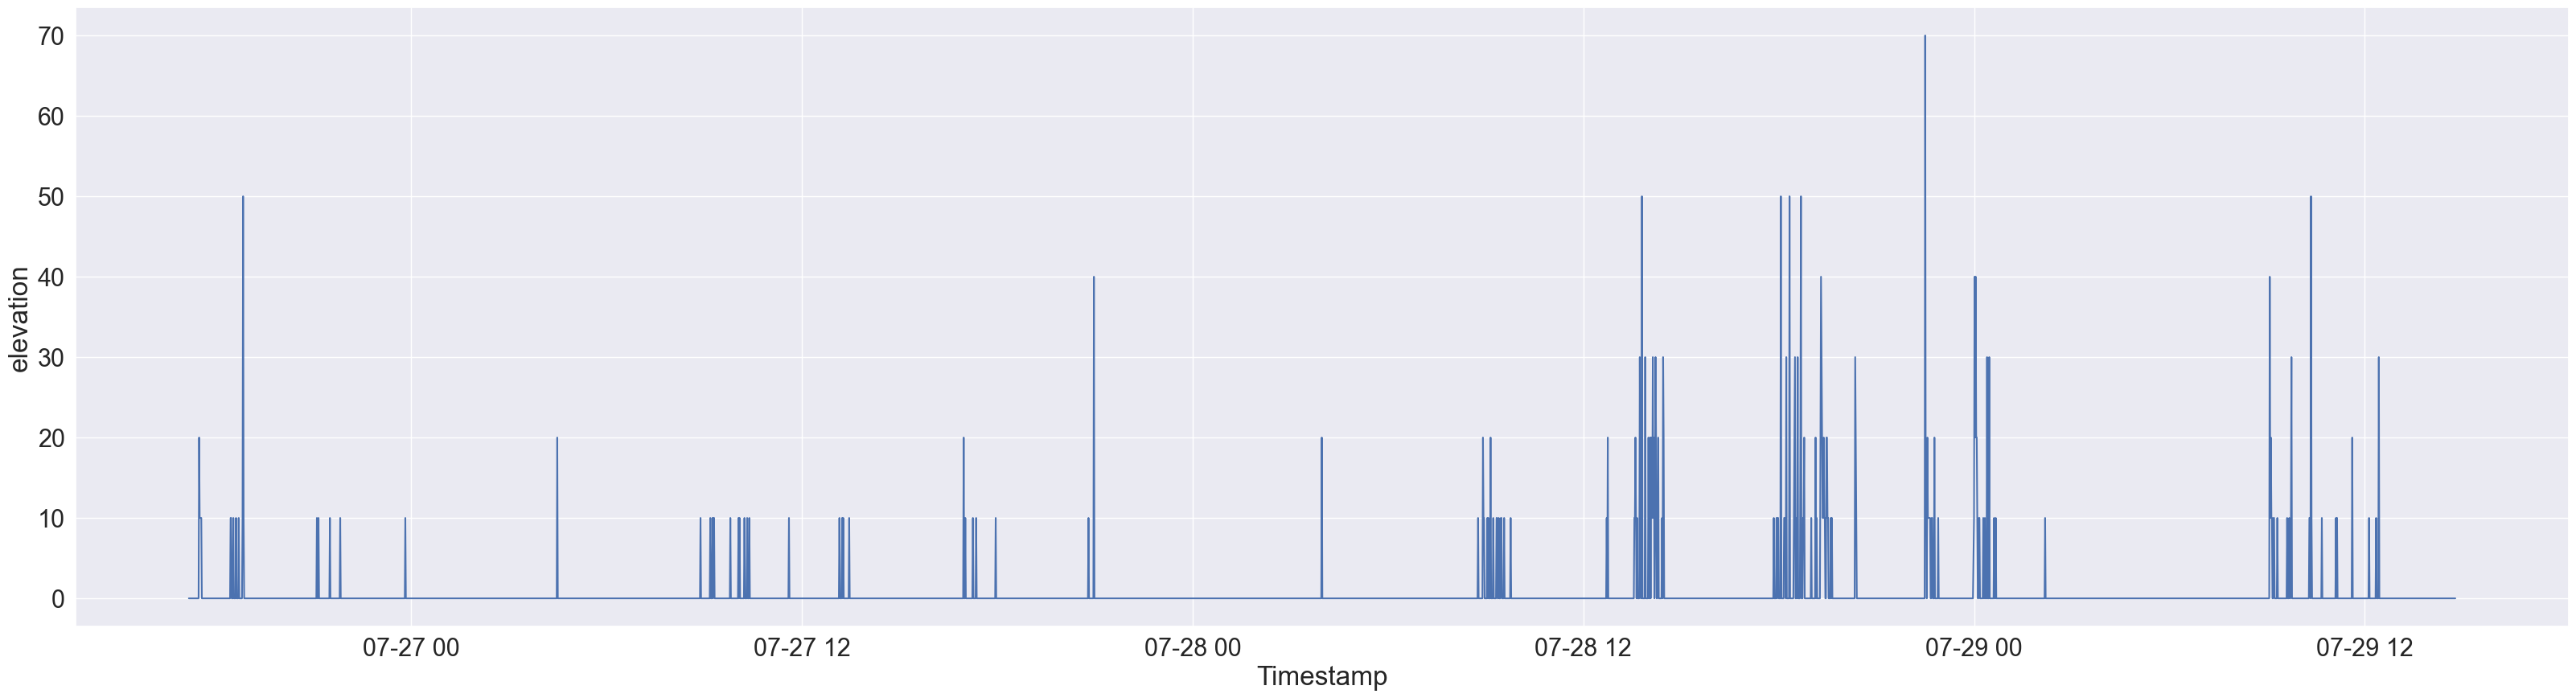

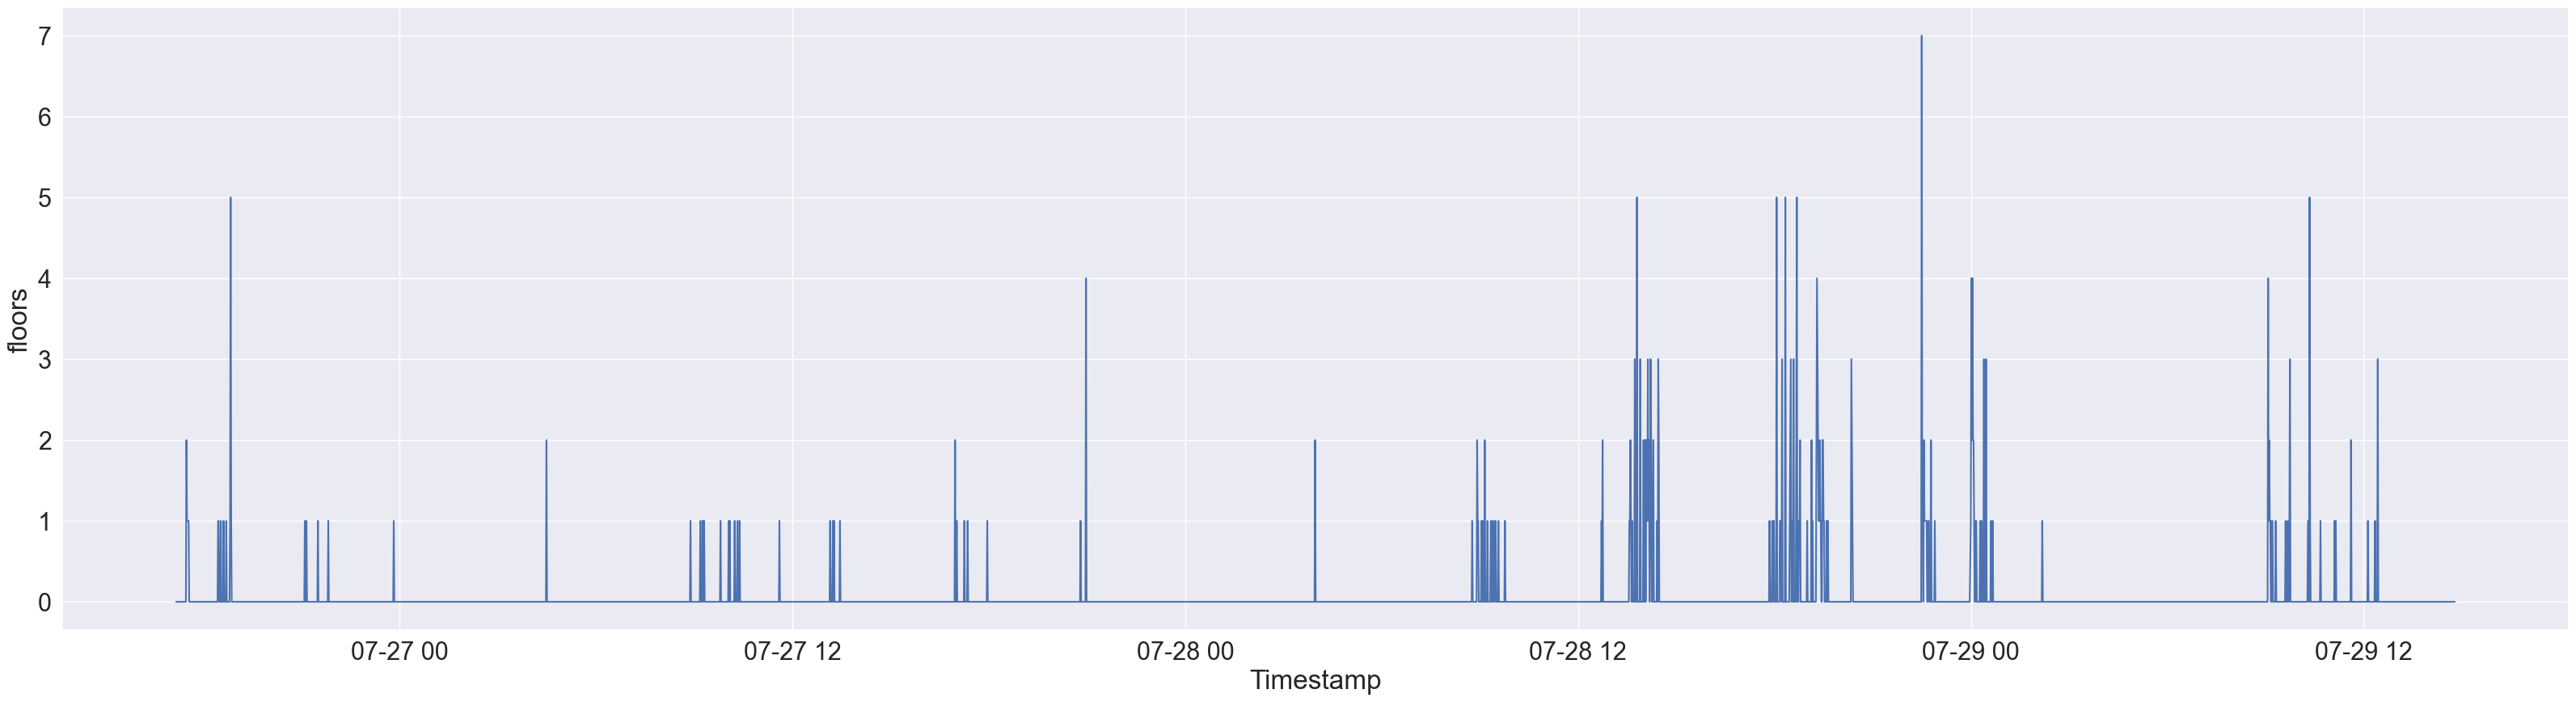

In [19]:
# Plot all time series data from to_date_fitbit_data  
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import HourLocator, DateFormatter, MinuteLocator

# list of columns to plot
cols_to_plot = ['heart', 'calories', 'steps', 'distance',
                'minutesSedentary', 'minutesLightlyActive', 'minutesFairlyActive',
                'minutesVeryActive', 'elevation', 'floors']  



for col in cols_to_plot:
    plt.figure(figsize=(40,10))
    sns.set(font_scale=2)
    
    # plot the data
    sns.lineplot(data=to_date_fitbit_data, x=to_date_fitbit_data.index, y=col)
    

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Heart Rate')
    ax1.set_title('NaN in HR are Blue (Index:0 is a Test Point)')

    # Create the second axes, inheriting the x-axis from the first one
    ax2 = ax1.twiny()

    # Set the x-axis labels as daytime
    date_format = DateFormatter("%H:%M:%S")  
    ax1.xaxis.set_major_formatter(date_format)

    # Set the x-axis ticks
    locator = HourLocator(interval=1, tz=None)
    ax1.xaxis.set_major_locator(locator)
    ax1.set_xlim(df_to_plot.index.min(), df_to_plot.index.max())


    # Format the second x-axis to show the date
    date_format_day = DateFormatter("%Y-%m-%d")  
    ax2.xaxis.set_major_formatter(date_format_day)
    ax2.set_xlim(df_to_plot.index.min(), df_to_plot.index.max())

    # Rotate x-axis labels on both axes
    ax1.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='x', rotation=45)

    plt.show()


    # plt.xlabel('Timestamp')
    # plt.ylabel(col)
    # plt.title(f'{col} over time')

    # # x-axis formatter and locator
    # date_format = DateFormatter("%H:%M")  
    # plt.gca().xaxis.set_major_formatter(date_format)
    
    # major_locator = HourLocator(interval=6)  # major ticks every hour
    # #minor_locator = MinuteLocator(interval=15)  # minor ticks every 15 minutes
    
    # plt.gca().xaxis.set_major_locator(major_locator)
    # plt.gca().xaxis.set_minor_locator(minor_locator)
    # plt.gca().set_xlim(to_date_fitbit_data.index.min(), to_date_fitbit_data.index.max())

    # plt.xticks(rotation=45)
    # plt.show()

